Successfully registered: Meet
OpenCV DNN found 1 face(s).


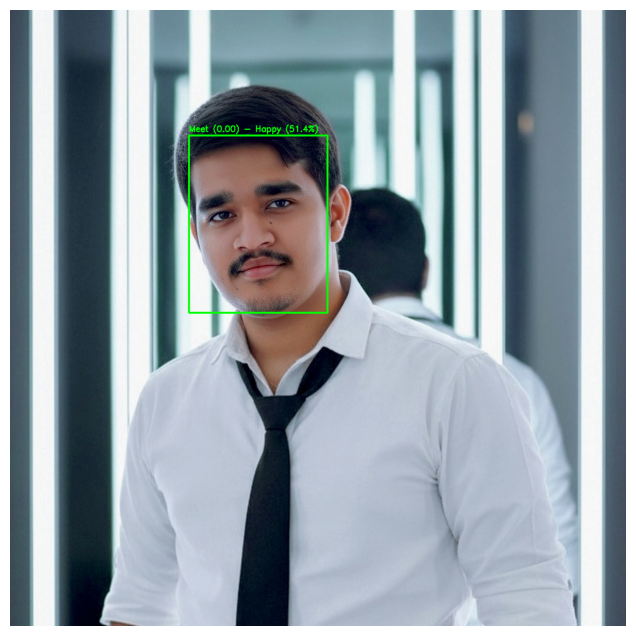

In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances
import urllib.request
import os

# ---------------------------------------------------------
# 1. Auto-Download OpenCV's Deep Learning Face Detector
# ---------------------------------------------------------
prototxt_url = "https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt"
model_url = "https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel"

prototxt_path = "deploy.prototxt"
model_path = "res10_300x300_ssd_iter_140000.caffemodel"

if not os.path.exists(prototxt_path):
    print("Downloading OpenCV DNN prototxt...")
    urllib.request.urlretrieve(prototxt_url, prototxt_path)
if not os.path.exists(model_path):
    print("Downloading OpenCV DNN model...")
    urllib.request.urlretrieve(model_url, model_path)

dnn_net = cv2.dnn.readNetFromCaffe(prototxt_path, model_path)

def detect_faces_dnn(image_rgb, confidence_threshold=0.5):
    h, w = image_rgb.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image_rgb, (300, 300)), 1.0,
                                 (300, 300), (104.0, 177.0, 123.0))
    dnn_net.setInput(blob)
    detections = dnn_net.forward()
    boxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > confidence_threshold:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            startX, startY = max(0, startX), max(0, startY)
            endX, endY = min(w, endX), min(h, endY)
            boxes.append((startX, startY, endX - startX, endY - startY))
    return boxes

# ---------------------------------------------------------
# 2. Simplified FaceNet Model (Embeddings)
# ---------------------------------------------------------
def build_custom_facenet(input_shape=(160, 160, 3), embedding_size=128):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(64, (5,5), strides=2, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2,2)(x)

    x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2,2)(x)

    x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2,2)(x)

    x = layers.Conv2D(512, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(embedding_size, activation=None)(x)
    embeddings = layers.Lambda(lambda tensor: tf.math.l2_normalize(tensor, axis=1))(x)
    return keras.Model(inputs, embeddings, name='Custom_FaceNet')

base_model = build_custom_facenet()

# ---------------------------------------------------------
# 3. Emotion Detection Model (Happy vs Not Happy)
# ---------------------------------------------------------
def build_emotion_model(input_shape=(48,48,1), num_classes=2):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, (3,3), activation='relu')(inputs)
    x = layers.MaxPooling2D(2,2)(x)
    x = layers.Conv2D(64, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D(2,2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inputs, outputs, name="HappyNet")

emotion_model = build_emotion_model()
emotion_labels = ["Not Happy", "Happy"]

def predict_emotion(face_crop):
    gray = cv2.cvtColor(face_crop, cv2.COLOR_RGB2GRAY)
    face_resized = cv2.resize(gray, (48,48))
    face_normalized = face_resized.astype('float32') / 255.0
    face_input = np.expand_dims(face_normalized, (0,-1))
    preds = emotion_model.predict(face_input, verbose=0)[0]
    emotion_idx = np.argmax(preds)
    return emotion_labels[emotion_idx], preds[emotion_idx]

# ---------------------------------------------------------
# 4. Database Registration
# ---------------------------------------------------------
known_database = {}

def register_user(name, image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not read {image_path}")
        return
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    boxes = detect_faces_dnn(img_rgb)
    if not boxes:
        print(f"No face detected in {image_path} to register.")
        return
    x, y, w, h = boxes[0]
    margin = int(min(w, h) * 0.1)
    x1, y1 = max(0, x - margin), max(0, y - margin)
    x2, y2 = min(img_rgb.shape[1], x + w + margin), min(img_rgb.shape[0], y + h + margin)
    face_crop = img_rgb[y1:y2, x1:x2]
    face_resized = cv2.resize(face_crop, (160, 160))
    face_normalized = face_resized.astype('float32') / 255.0
    emb = base_model.predict(np.expand_dims(face_normalized, 0), verbose=0)[0]
    known_database[name] = emb
    print(f"Successfully registered: {name}")

# ---------------------------------------------------------
# 5. Multi-Face Recognition + Happy Detection
# ---------------------------------------------------------
def process_group_photo(image_path, threshold=0.5):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not read {image_path}")
        return
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    boxes = detect_faces_dnn(img_rgb)
    print(f"OpenCV DNN found {len(boxes)} face(s).")

    for (x, y, w, h) in boxes:
        margin = int(min(w, h) * 0.1)
        x1, y1 = max(0, x - margin), max(0, y - margin)
        x2, y2 = min(img_rgb.shape[1], x + w + margin), min(img_rgb.shape[0], y + h + margin)
        face_crop = img_rgb[y1:y2, x1:x2]
        if face_crop.size == 0: continue

        # Face embedding
        face_resized = cv2.resize(face_crop, (160, 160))
        face_normalized = face_resized.astype('float32') / 255.0
        emb = base_model.predict(np.expand_dims(face_normalized, 0), verbose=0)[0]

        # Recognition
        label = "Unknown"
        color = (255, 0, 0)
        best_dist = float('inf')
        if known_database:
            distances = cosine_distances([emb], list(known_database.values()))[0]
            min_idx = np.argmin(distances)
            min_dist = distances[min_idx]
            if min_dist < threshold:
                label = list(known_database.keys())[min_idx]
                color = (0, 255, 0)
                best_dist = min_dist

        # Emotion (Happy vs Not Happy)
        emotion, confidence = predict_emotion(face_crop)

        # Draw results
        cv2.rectangle(img_rgb, (x, y), (x+w, y+h), color, 3)
        text = f"{label} ({best_dist:.2f}) - {emotion} ({confidence*100:.1f}%)" \
               if label != "Unknown" else f"{label} - {emotion} ({confidence*100:.1f}%)"
        cv2.putText(img_rgb, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

    plt.figure(figsize=(12, 8))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

# =========================================================
# 6. Execute the Lab
# =========================================================
if __name__ == "__main__":
    known_database.clear()

    # Example: Register known users
    # Replace with actual image paths of single-face photos
    register_user("Meet", "meet.jpg")

    # Group photo for testing
    test_image = "meet.jpg"

    # Run detection + recognition + happy detection
    process_group_photo(test_image, threshold=0.5)